Hi, Marcel! 

Hope it'll help you to run my code quicker :)

Alex

## Input format

| ID |     Name    | FA_Name | Value |
|---:|:-----------:|:-------:|-------|
|  1 | Revenue_123 | Revenue | -100  |
where **ID** - is actual Business Processes ID, **Name** is the full name of FinancialAccount (not sure that it's required, but initially as I guess one has something like "Revenue_1", "Revenue_2" for different product and only after application of Coarse-graining financial accounts we are getting **FA_Name** value. **Value** is just a amount.
## Extraction signatures of BP
For that purpose I've implemented aggregation function over *groupby()* object, as input it uses one BP – a part of original DF with the same ID value – and return a string like
```
'([(\\'Revenue\\', 0.8336558167088283), (\\'Tax\\', 0.1663441832911717)], [(\\'TradeReceivables\\', 1.0)])'
```
then we leave only unique signatures (SAME FA from left and right part AND EXACTLY EQUAL coefficients).
## Data preprocessing
Then on that DataFrame you need to apply [*prepare_data()*](https://github.com/AlexWorldD/NetEmbs/blob/master/NetEmbs/DataProcessing/prepare_data.py) - please read the documentation to that function. The last thing I've added is 
```
 :param unique: True if Data has to be filtered wrt to Signatures of BPs
 ```

After that you should get the following structure:

| ID |     Name    | FA_Name | Value | Debit | Credit | from |
|---:|:-----------:|:-------:|-------|-------|--------|------|
|  1 | Revenue_123 | Revenue | -100  | 0.0   | 1.0    | True |

here **from** is for visualization purposes only (different colors of ingoing/outgoing edges)
## Construct FSN
Now we can construct FSN from our DataFrame, *build()* method of *FSN* class. 

I recommend to check the construction via *get_FA()* method, it should return the set of Financial Account nodes.
## RandomWalks
#### Already implemented step strategies
1. Pure RandomWalk (uniform probabilities, follows the direction)
2. MetaDef (change directions, uniform probabilities)
3. MetaDefWeighted (change directions, weighted probabilities "rich gets richer")
4. MetaDiff (change directions, probabilities depend on the differences between edges)

For test purpose you can try *randomWalk()* from NetEmbs.FSN.utils, it returns the sampled sequence. 

**BUT**, I've implemented special helper funciton for adding to original DataFrame a column with N top joint-appearance nodes. It's *add_similar()* function from NetEmbs.FSN.utils.

You also can test it with different step strategies: "DefUniform", "DefWeighted", "MetaUniform", "MetaWeighted", "MetaDiff" (version argument).

### Example with sampled data

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
plt.rcParams["figure.figsize"] = [20,10]
from NetEmbs.DataProcessing.normalize import normalize
from NetEmbs.DataProcessing.connect_db import *
from NetEmbs.GenerateData.complex_df import sales_collections
d = upload_data("Simulation/FSN_Data.db", limit=100)
d.head(5)

,ID,Name,FA_Name,Value
0,1,Revenue_2,Revenue,-921.000000
1,1,Tax_2,Tax,-193.731819
2,1,TradeReceivables_2,TradeReceivables,1114.731819
3,2,opwdiu_3,opwdiu,-8.052642
4,2,eucdcj_3,eucdcj,8.037404


### Marcel, below you can test your input format, it should work correctly

Taking into account that real data already has two columns with debited and credited amounts, for preprocessing it you need to apply sequentially 

*rename_columns()*

with default arguments it's fit for your column titles and then 

*prepare_data(..., split=False)*

In [3]:
from NetEmbs.DataProcessing import *
journal_entries = None
if journal_entries is None:
    d = prepare_data(d)
else:
    YOUR_DATAFRAME = pd.DataFrame.from_dict(journal_entries)
    YOUR_DATAFRAME.columns = ['ID', 'FA_Name', 'Debit', 'Credit']
    d = prepare_data(YOUR_DATAFRAME, split=False)
d.head(20)

,ID,Signature,FA_Name,Debit,Credit,from
0,1,"([('Revenue', 0.82621), ('Tax', 0.17379)], [('...",Revenue,0.000000,0.826208,True
1,1,"([('Revenue', 0.82621), ('Tax', 0.17379)], [('...",Tax,0.000000,0.173792,True
2,1,"([('Revenue', 0.82621), ('Tax', 0.17379)], [('...",TradeReceivables,1.000000,0.000000,False
3,2,"([('Inventory', 0.98588), ('balzki', 0.00538),...",CostOfSales,0.991273,0.000000,False
4,2,"([('Inventory', 0.98588), ('balzki', 0.00538),...",Inventory,0.000000,0.985881,True
5,2,"([('Inventory', 0.98588), ('balzki', 0.00538),...",balzki,0.000000,0.005376,True
6,2,"([('Inventory', 0.98588), ('balzki', 0.00538),...",eucdcj,0.008727,0.000000,False
7,2,"([('Inventory', 0.98588), ('balzki', 0.00538),...",opwdiu,0.000000,0.008743,True
8,3,"([('Cash', 1.0)], [('Tax', 1.0)])",Cash,0.000000,1.000000,True
9,3,"([('Cash', 1.0)], [('Tax', 1.0)])",Tax,1.000000,0.000000,False


In [4]:
from NetEmbs.FSN.graph import FSN
fsn = FSN()
fsn.build(d, name_column="FA_Name")
fsn.nodes()

NodeView((1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17, 18, 21, 22, 24, 27, 29, 'Revenue', 'Tax', 'TradeReceivables', 'CostOfSales', 'Inventory', 'balzki', 'eucdcj', 'opwdiu', 'Cash', 'EBPayables', 'PersonnelExpenses', 'sxnkol', 'uzbcge', 'vbzovt', 'devoji', 'diajgb', 'FixedAssets', 'TradePayables', 'emdmug', 'OtherExpenses', 'PrepaidExpenses', 'dqiihn', 'epbcyx', 'uzvqin', 'DepreciationExpense', 'izolmo', 'kaxwdy', 'nfpqhp', 'zupdhg', 'bzxaqi', 'fgftgk', 'gdsgne', 'woeqep', 'irmzan', 'swxmeh', 'uvdxts', 'yluoun', 'fgnsst', 'ndznzg', 'qeclna', 'qjnldx'))

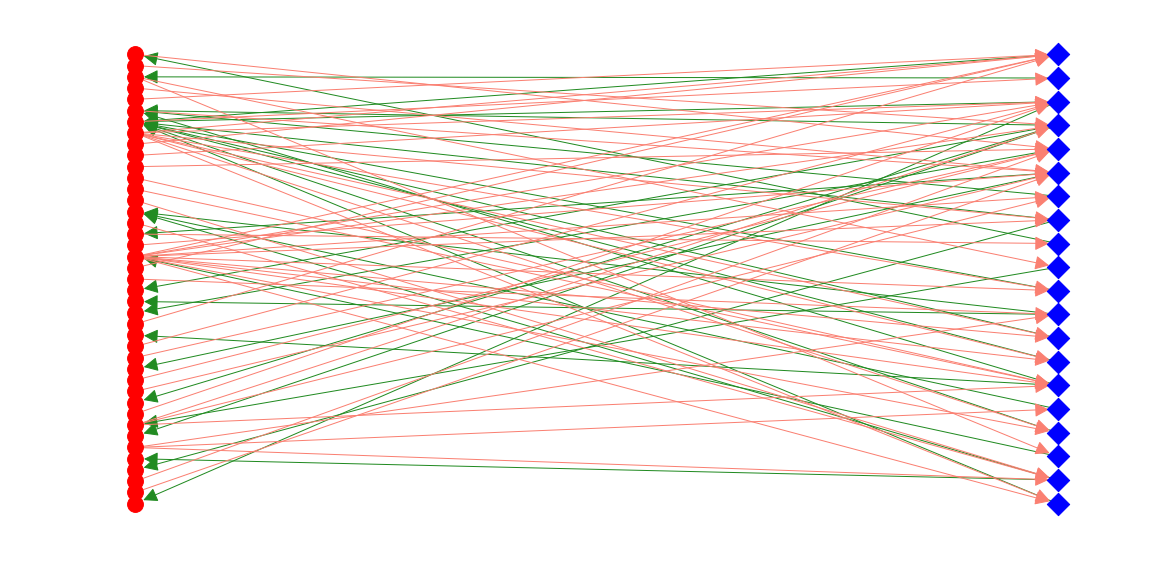

In [5]:
from NetEmbs.Vis.plots import plotFSN
plotFSN(fsn, edge_labels=False, node_labels=False)

In [6]:
from NetEmbs.FSN.utils import add_similar, get_pairs
add_similar(d, direction="COMBI").head(5)

,ID,Signature,FA_Name,Debit,Credit,from,Similar_BP
0,1,"([('Revenue', 0.82621), ('Tax', 0.17379)], [('...",Revenue,0.000000,0.826208,True,"[(24, 78), (11, 74), (9, 68)]"
1,1,"([('Revenue', 0.82621), ('Tax', 0.17379)], [('...",Tax,0.000000,0.173792,True,"[(24, 78), (11, 74), (9, 68)]"
2,1,"([('Revenue', 0.82621), ('Tax', 0.17379)], [('...",TradeReceivables,1.000000,0.000000,False,"[(24, 78), (11, 74), (9, 68)]"
3,2,"([('Inventory', 0.98588), ('balzki', 0.00538),...",CostOfSales,0.991273,0.000000,False,"[(10, 171), (5, 160)]"
4,2,"([('Inventory', 0.98588), ('balzki', 0.00538),...",Inventory,0.000000,0.985881,True,"[(10, 171), (5, 160)]"


## Testing different Pairs construction

In [ ]:
from NetEmbs.FSN import *
randomWalk(fsn, 1, length=10, direction="COMBI")

In [ ]:
list(fsn.successors(7)), list(fsn.predecessors(7))

In [ ]:
d["ID"].unique()

In [7]:
from NetEmbs.FSN.utils import similar
from NetEmbs.Logs.custom_logger import log_me
pd.set_option('display.max_colwidth', -1)
MAIN_LOGGER = log_me()
MAIN_LOGGER.info("Started..")
d = prepare_data(upload_data("Simulation/FSN_Data.db", limit=200))
similar(d, direction=["COMBI"]).head(15)

Done with extraction Journal Entries data!
Done with RandomWalking... Found  3  top


,ID,Signature,MetaDiff_COMBI
0,1,"([('Revenue', 0.82621), ('Tax', 0.17379)], [('TradeReceivables', 1.0)])","[([('Revenue', 0.82745), ('Tax', 0.17255)], [('TradeReceivables', 1.0)]), ---------, ([('Revenue', 0.82775), ('Tax', 0.17225)], [('TradeReceivables', 1.0)]), ---------, ([('Revenue', 0.82672), ('Tax', 0.17328)], [('TradeReceivables', 1.0)]), ---------]"
1,2,"([('Inventory', 0.98588), ('balzki', 0.00538), ('opwdiu', 0.00874)], [('CostOfSales', 0.99127), ('eucdcj', 0.00873)])","[([('Inventory', 0.99095), ('kaljas', 0.00311), ('lxohur', 0.00351), ('rmntvs', 0.00244)], [('CostOfSales', 0.99462), ('llkees', 0.00538)]), ---------, ([('Inventory', 0.9826), ('hkdbrq', 0.00441), ('nmmjft', 0.00397), ('vkraxy', 0.00901)], [('CostOfSales', 1.0)]), ---------, ([('Inventory', 1.0)], [('CostOfSales', 1.0)]), ---------]"
2,3,"([('Cash', 1.0)], [('Tax', 1.0)])","[([('Cash', 1.0)], [('EBPayables', 1.0)]), ---------]"
3,4,"([('Revenue', 0.9434), ('Tax', 0.0566)], [('TradeReceivables', 1.0)])","[([('Revenue', 0.93724), ('Tax', 0.05615), ('fgnsst', 0.00207), ('ndznzg', 0.00057), ('qeclna', 0.00297), ('qjnldx', 0.001)], [('TradeReceivables', 1.0)]), ---------, ([('Revenue', 0.81634), ('Tax', 0.17202), ('irmzan', 0.00395), ('swxmeh', 0.00156), ('uvdxts', 0.00613)], [('TradeReceivables', 0.99405), ('yluoun', 0.00595)]), ---------, ([('Revenue', 0.94355), ('Tax', 0.05645)], [('TradeReceivables', 1.0)]), ---------]"
4,5,"([('Inventory', 1.0)], [('CostOfSales', 1.0)])","[([('Inventory', 0.9826), ('hkdbrq', 0.00441), ('nmmjft', 0.00397), ('vkraxy', 0.00901)], [('CostOfSales', 1.0)]), ---------, ([('Inventory', 0.9944), ('devoji', 0.0056)], [('CostOfSales', 0.99902), ('diajgb', 0.00098)]), ---------, ([('Inventory', 0.98588), ('balzki', 0.00538), ('opwdiu', 0.00874)], [('CostOfSales', 0.99127), ('eucdcj', 0.00873)]), ---------]"
5,6,"([('EBPayables', 0.78677), ('Tax', 0.21), ('uzbcge', 0.0018), ('vbzovt', 0.00143)], [('PersonnelExpenses', 0.99963), ('sxnkol', 0.00037)])","[([('EBPayables', 0.78975), ('Tax', 0.21), ('gdsgne', 0.00025)], [('PersonnelExpenses', 0.99649), ('bzxaqi', 0.00207), ('fgftgk', 0.00087), ('woeqep', 0.00057)]), ---------, ([('EBPayables', 0.79), ('Tax', 0.21)], [('PersonnelExpenses', 1.0)]), ---------, ([('Revenue', 0.82775), ('Tax', 0.17225)], [('TradeReceivables', 1.0)]), ---------]"
6,7,"([('Revenue', 0.82745), ('Tax', 0.17255)], [('TradeReceivables', 1.0)])","[([('Revenue', 0.81634), ('Tax', 0.17202), ('irmzan', 0.00395), ('swxmeh', 0.00156), ('uvdxts', 0.00613)], [('TradeReceivables', 0.99405), ('yluoun', 0.00595)]), ---------, ([('Revenue', 0.82621), ('Tax', 0.17379)], [('TradeReceivables', 1.0)]), ---------, ([('Revenue', 0.82672), ('Tax', 0.17328)], [('TradeReceivables', 1.0)]), ---------]"
7,9,"([('Revenue', 0.82775), ('Tax', 0.17225)], [('TradeReceivables', 1.0)])","[([('Revenue', 0.82621), ('Tax', 0.17379)], [('TradeReceivables', 1.0)]), ---------, ([('Revenue', 0.82745), ('Tax', 0.17255)], [('TradeReceivables', 1.0)]), ---------, ([('Revenue', 0.81634), ('Tax', 0.17202), ('irmzan', 0.00395), ('swxmeh', 0.00156), ('uvdxts', 0.00613)], [('TradeReceivables', 0.99405), ('yluoun', 0.00595)]), ---------]"
8,10,"([('Inventory', 0.9944), ('devoji', 0.0056)], [('CostOfSales', 0.99902), ('diajgb', 0.00098)])","[([('Inventory', 0.99333), ('hfjpzp', 0.00667)], [('CostOfSales', 0.99001), ('ddublc', 0.00552), ('jvwxot', 0.00447)]), ---------, ([('Inventory', 0.99095), ('kaljas', 0.00311), ('lxohur', 0.00351), ('rmntvs', 0.00244)], [('CostOfSales', 0.99462), ('llkees', 0.00538)]), ---------, ([('Inventory', 1.0)], [('CostOfSales', 1.0)]), ---------]"
9,11,"([('Revenue', 0.82525), ('Tax', 0.17475)], [('TradeReceivables', 1.0)])","[([('Revenue', 0.82302), ('Tax', 0.17131), ('cewfdm', 0.00567)], [('TradeReceivables', 0.98961), ('cdwyug', 0.00643), ('deesvq', 0.00396)]), ---------, ([('Revenue', 0.82745), ('Tax', 0.17255)], [('TradeReceivables', 1.0)]), ---------, ([('Revenue', 0.81634), ('Tax', 0.17202), ('irmzan', 0.00395), ('swxmeh

## Tests

In [ ]:
from NetEmbs.FSN.utils import make_pairs
t = [1,2,3,1,2]
out = make_pairs(t, window=2)
out

# Skip-Gram model
Previously we've gotten a list of tuples where the first item is input word in term of Skip-gram model and the second item is output word. Hence, one can implement the simplest skip-gram model over it.

In [ ]:
from NetEmbs.FSN.utils import *
skip_grams, fsn, enc_dec = get_SkipGrams(d)
skip_grams[:5]

### Batch function

In [ ]:
def generate_batch(all_data, batch_size):
    _t = np.random.randint(0, len(all_data), batch_size)
    batch = np.ndarray(shape=(batch_size), dtype=np.int32, buffer=np.array([all_data[t][0] for t in _t]))
    context = np.ndarray(shape=(batch_size, 1), dtype=np.int32, buffer=np.array([all_data[t][1] for t in _t]))
    return batch, context

In [ ]:
generate_batch(skip_grams[:100], 3)

### TensorFlow

In [7]:
from NetEmbs.SkipGram import *
import seaborn as sns

In [8]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

res = get_embs_TF(path_file="Simulation/FSN_Data.db")

[(0, 45), (0, 9), (0, 45), (45, 0), (45, 9)]
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Initialized
Average train loss at step  0 :  3.6601104736328125
Nearest to 9: 136, 1, 98,
Nearest to 6: 158, 4, 24,
Nearest to 29: 3, 5, 111,
Nearest to 143: 161, 111, 29,
Average train loss at step  1000 :  1.0972310366332532
Average train loss at step  2000 :  0.5268378601968289
Average train loss at step  3000 :  0.4642382445782423
Average train loss at step  4000 :  0.3957524511665106
Average train loss at step  5000 :  0.3407761472016573
Nearest to 9: 66, 98, 73,
Nearest to 6: 136, 152, 17,
Nearest to 29: 111, 159, 4,
Nearest to 143: 156, 159, 123,
Average train loss at step  6000 :  0.30323230497539044
Average train loss at step  7000 :  0.28166744277626277
Average train loss at step  8000 :  0.2649677169471979
Average train loss at step  9000 :  0.26414986887574193
Average train loss at step  10000 :  0.2604339492619038
Nearest to 9: 89,

Collections


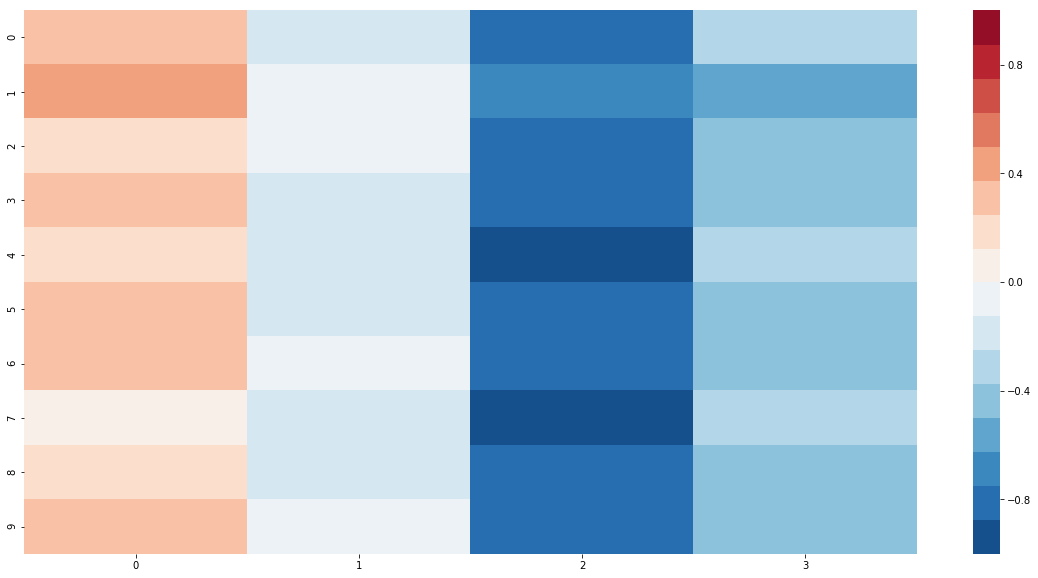

Cost of Sales


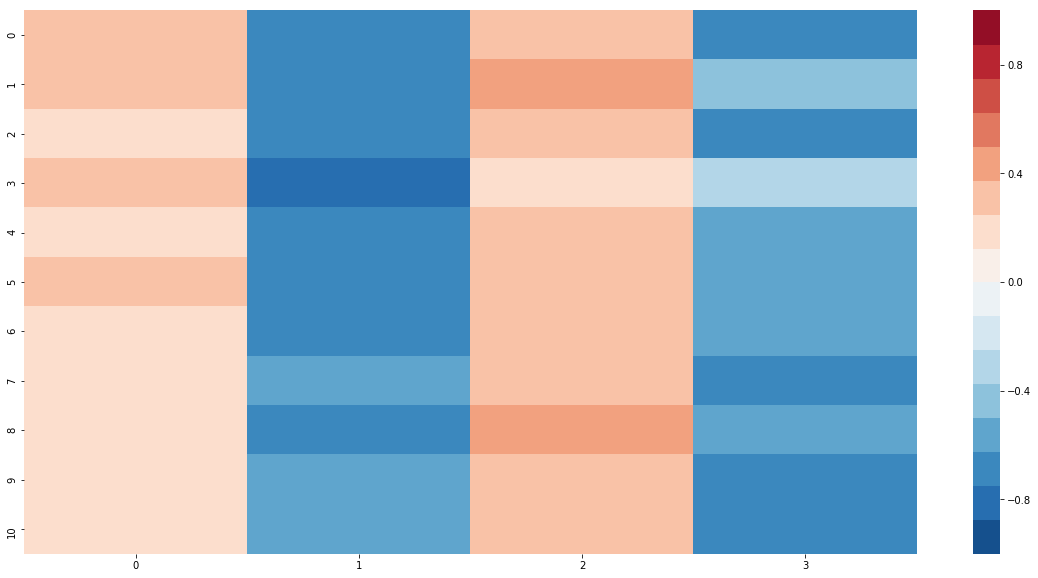

Depreciation


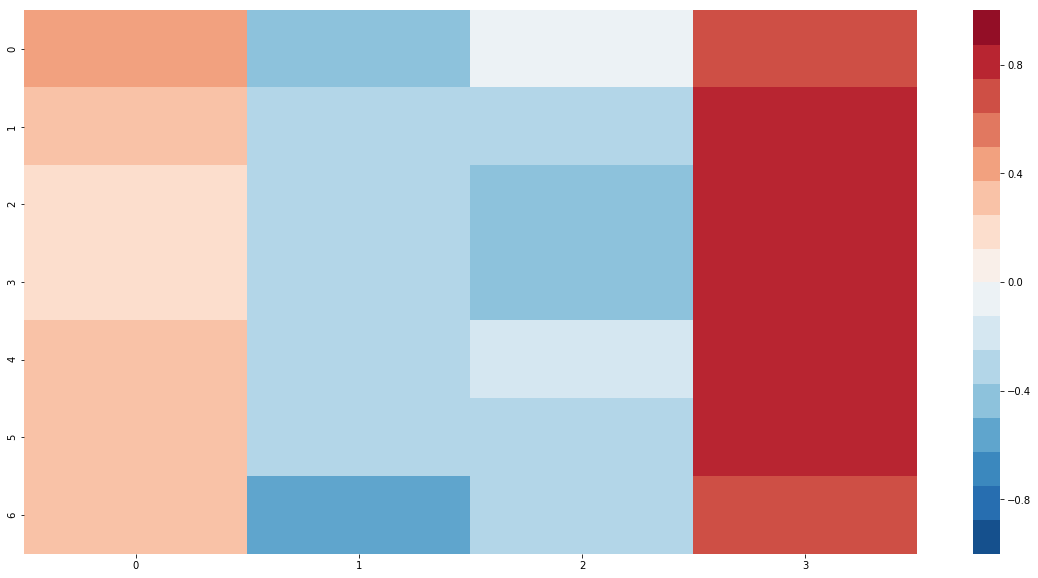

Fixed Assets
Not enough samples...
Payroll


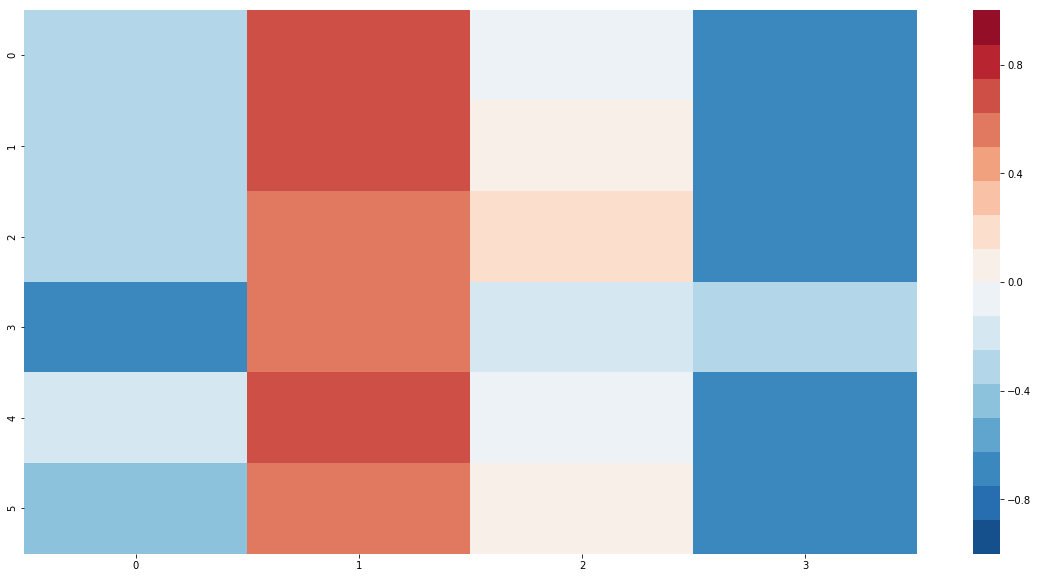

Payroll Disbursement
Not enough samples...
Purchase
Not enough samples...
Sales 21 btw


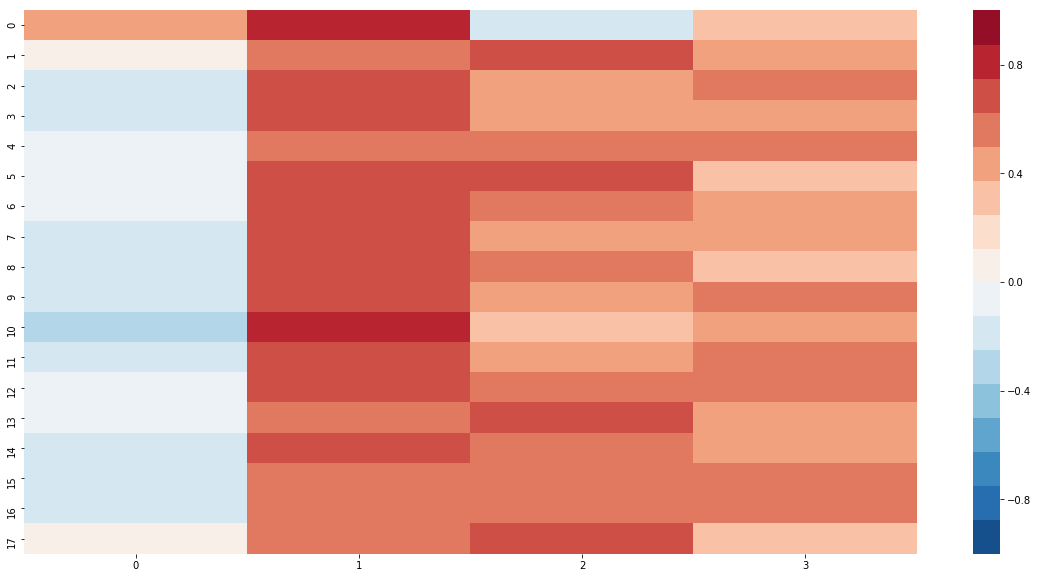

Sales 6 btw


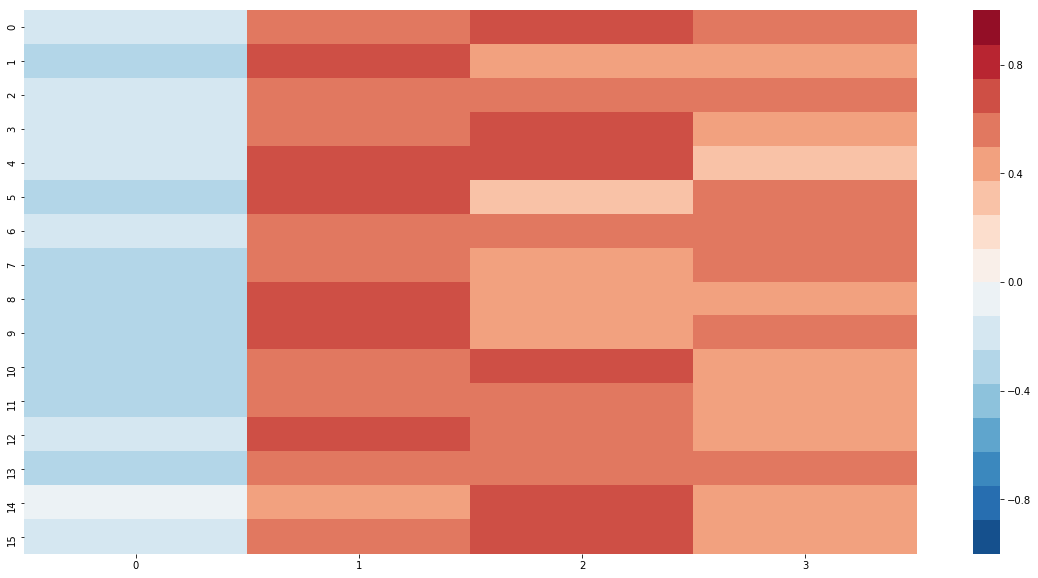

Tax disbursement
Not enough samples...


In [9]:
for name, group in res.groupby("FA_Name"):
    print(name)
    if group.shape[0] > 3:
        sns.heatmap(list(group["Emb"].values), vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 16))
        plt.show()
    else:
        print("Not enough samples...")

In [11]:
res2 = get_embs_TF(path_file="Simulation/FSN_Data.db", num_steps=50000, walks_per_node=50, walk_length=20)

[(0, 53), (0, 64), (0, 36), (53, 0), (53, 64)]
Initialized
Average train loss at step  0 :  4.119760513305664
Nearest to 80: 21, 89, 50,
Nearest to 114: 109, 9, 164,
Nearest to 154: 92, 102, 113,
Nearest to 79: 140, 32, 17,
Average train loss at step  1000 :  1.0925621399581433
Average train loss at step  2000 :  0.5274062504172325
Average train loss at step  3000 :  0.4710579881966114
Average train loss at step  4000 :  0.41071358959376814
Average train loss at step  5000 :  0.35820774333178995
Nearest to 80: 27, 113, 52,
Nearest to 114: 42, 92, 63,
Nearest to 154: 66, 15, 7,
Nearest to 79: 5, 162, 47,
Average train loss at step  6000 :  0.3126120674610138
Average train loss at step  7000 :  0.29350748705863955
Average train loss at step  8000 :  0.2830204212591052
Average train loss at step  9000 :  0.27212029916793107
Average train loss at step  10000 :  0.2707072667814791
Nearest to 80: 113, 140, 27,
Nearest to 114: 42, 92, 21,
Nearest to 154: 7, 29, 15,
Nearest to 79: 162, 47, 5,


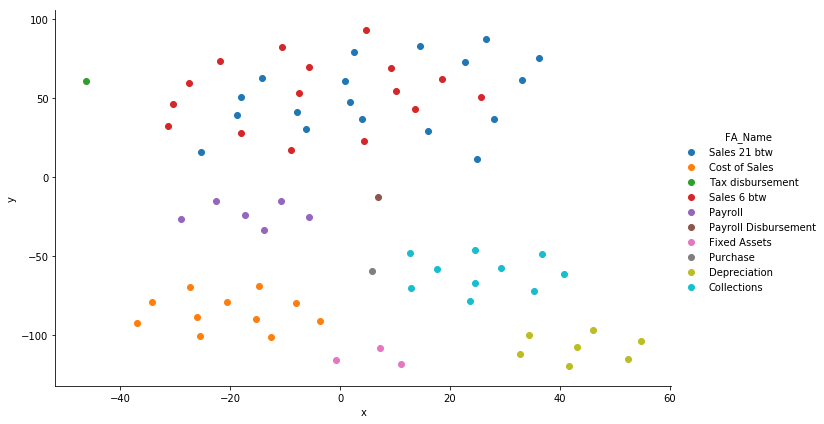

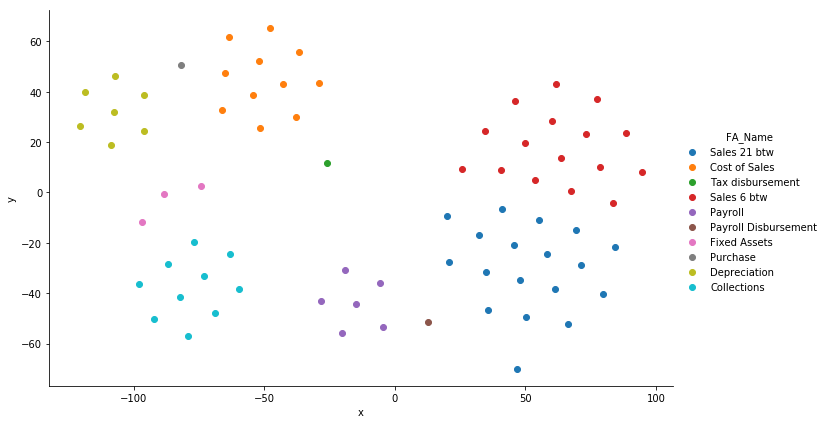

In [13]:
def plot_tSNE(fsn_embs):
    import os
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    tsne = TSNE()
    embdf = pd.DataFrame(list(map(np.ravel, fsn_embs.iloc[:, 1])))
    embed_tsne = tsne.fit_transform(embdf)
    fsn_embs["x"] = pd.Series(embed_tsne[:, 0])
    fsn_embs["y"] = pd.Series(embed_tsne[:, 1])
    import seaborn as sns
    fg = sns.FacetGrid(data=fsn_embs, hue='FA_Name', aspect=1.61, height=6)
    fg.map(pyplot.scatter, 'x', 'y').add_legend()
    plt.plot()
    return fsn_embs
dd = plot_tSNE(res)
_ = plot_tSNE(res2)